## LSTM Neural network with class balancing
**author** : Chandana Chaudhry


There are two main types of language models: *statistical models* and *neural models*. Here, we will only focus on neural network approaches to developing a language model. So far in our coverage of neural networks we have seen Fully-Connected Neural Networks (FNN) as well as Convolutional Neural Networks (CNN). These were powerful architectures, but neither work well on sequential data where the ordering of inputs matter.

Here are two key architectures that are used for in language modeling:

* **Recurrent neural networks (RNNs)**: RNNs are able to take the order of the input data into account. This ability makes them well-suited for tasks such as text classification and natural language generation.

* **Self-attention and transformer networks**: Self-attention and transformer networks are able to learn long-range dependencies in the input data. This ability makes them well-suited for tasks such as machine translation and question answering.


`LSTM`: _Long-Short Term Memory_ units (introduced by [Hochreiter & Schmidhuber, 1997.](https://dl.acm.org/doi/10.1162/neco.1997.9.8.1735)) which improve on simple RNNs with advanced long-term memory updates;

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [16]:
df_neural = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
df_neural.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


The target variable ('Sentiment') is defined based on the 'Rating' column. Ratings 4 and 5 are labeled as 'positive', rating 3 as 'neutral', and ratings 1 and 2 as 'negative'.

In [17]:
# Filter out missing values and select relevant columns
df_neural = df_neural.dropna(subset=['Review Text', 'Rating'])
df_neural = df_neural[['Review Text', 'Rating']]

# Define target variable (positive sentiment for ratings 4 and 5, neutral for rating 3, negative for ratings 1 and 2)
df_neural['Sentiment'] = np.where(df_neural['Rating'] >= 4, 'positive', np.where(df_neural['Rating'] == 3, 'neutral', 'negative'))

In [18]:
df_neural.head()

,Review Text,Rating,Sentiment
0,Absolutely wonderful - silky and sexy and comf...,4,positive
1,Love this dress! it's sooo pretty. i happene...,5,positive
2,I had such high hopes for this dress and reall...,3,neutral
3,"I love, love, love this jumpsuit. it's fun, fl...",5,positive
4,This shirt is very flattering to all due to th...,5,positive


- **Tokenization and Padding**:

The text data ('Review Text') is tokenized using Tokenizer and converted into sequences of integers using texts_to_sequences().
Sequences are padded to ensure that they are of equal length using pad_sequences().
- **One-Hot Encoding**:

The target variable ('Sentiment') is one-hot encoded using pd.get_dummies().
Training Word2Vec Model:

- The text data is split into individual words, and a Word2Vec model is trained using Word2Vec.

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_neural['Review Text'])

In [21]:
# Convert text data to sequences
X = tokenizer.texts_to_sequences(df_neural['Review Text'])

In [22]:
# Pad sequences to make them of equal length
maxlen = 100  # Maximum sequence length
X = pad_sequences(X, padding='post', maxlen=maxlen)

In [23]:
# Convert sentiment labels to one-hot encoding
y = pd.get_dummies(df_neural['Sentiment']).values

In [24]:
from gensim.models import Word2Vec
from sklearn.utils.class_weight import compute_class_weight

### word2vec model

Here, we create a Word2Vec model using the Word2Vec class from the gensim library. We pass the sentences list of tokenized reviews as input to the model. The parameters vector_size, window, min_count, and workers define the characteristics of the Word2Vec model:

vector_size: This parameter sets the dimensionality of the word vectors. In this case, we've set it to 100, meaning each word will be represented as a 100-dimensional vector.
window: This parameter determines the maximum distance between the current and predicted word within a sentence. It defines the size of the context window for learning word embeddings. Here, it's set to 5.
min_count: This parameter specifies the minimum frequency count of words. Words with frequency less than this count will be ignored. Setting it to 1 ensures that all words are considered.
workers: This parameter sets the number of worker threads to train the model. Increasing this parameter speeds up training by utilizing multiple CPU cores.
Here, it's set to 4, meaning training will use four CPU cores.

In [25]:
# Train Word2Vec model
sentences = [review.split() for review in df_neural['Review Text']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [26]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Create embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:  # Check if word exists in Word2Vec model's vocabulary
        embedding_matrix[i] = word2vec_model.wv[word]  # Retrieve word vector

####**Creating Embedding Matrix**:

An embedding matrix is created using the Word2Vec embeddings. Words present in the tokenizer's word index are mapped to their corresponding word vectors from the Word2Vec model.
Calculating Class Weights:

Class weights are computed using compute_class_weight() to handle class imbalance.

In [29]:
from sklearn.utils.class_weight import compute_class_weight


In [33]:
# Calculate class weights

class_weights = compute_class_weight('balanced', classes=['negative', 'neutral', 'positive'], y=df_neural['Sentiment'])
class_weights_dict = dict(zip(np.unique(df_neural['Sentiment']), class_weights))


In [39]:
# Create a mapping from class labels to integer indices
class_label_indices = {label: idx for idx, label in enumerate(np.unique(df_neural['Sentiment']))}

# Create the class weights dictionary using integer indices
class_weights_dict = {class_label_indices[label]: weight for label, weight in zip(np.unique(df_neural['Sentiment']), class_weights)}

## LSTM Model for text

###**Building the LSTM Model**:

- A Sequential model is initialized.
An embedding layer is added with pre-trained Word2Vec embeddings.
Multiple LSTM layers are added with dropout regularization.
Dense layers with activation functions are added for classification.
Compiling the Model:

- The model is compiled with categorical crossentropy loss and Adam optimizer.
Training the Model:

- The model is trained using fit(), with class weights applied to handle class imbalance.
Evaluating the Model:

- The trained model is evaluated on the test data, and test loss and accuracy are printed.



In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout

In [40]:
# Create LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [41]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
# Train the model with class weights
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), class_weight=class_weights_dict)

Epoch 1/10
142/142 [==============================] - 161s 1s/step - loss: 1.0122 - accuracy: 0.5880 - val_loss: 0.7089 - val_accuracy: 0.7414
Epoch 2/10
142/142 [==============================] - 152s 1s/step - loss: 0.9069 - accuracy: 0.6642 - val_loss: 0.6190 - val_accuracy: 0.7412
Epoch 3/10
142/142 [==============================] - 153s 1s/step - loss: 0.9020 - accuracy: 0.6577 - val_loss: 0.6749 - val_accuracy: 0.7112
Epoch 4/10
142/142 [==============================] - 152s 1s/step - loss: 0.8480 - accuracy: 0.7011 - val_loss: 0.7173 - val_accuracy: 0.6635
Epoch 5/10
142/142 [==============================] - 154s 1s/step - loss: 0.8205 - accuracy: 0.7086 - val_loss: 0.6385 - val_accuracy: 0.7357
Epoch 6/10
142/142 [==============================] - 154s 1s/step - loss: 0.8009 - accuracy: 0.7188 - val_loss: 0.7889 - val_accuracy: 0.6624
Epoch 7/10
142/142 [==============================] - 153s 1s/step - loss: 0.7835 - accuracy: 0.7253 - val_loss: 0.5710 - val_accuracy: 0.7216

Epoch 1/5
142/142 [==============================] - 154s 1s/step - loss: 0.7259 - accuracy: 0.7494 - val_loss: 0.5318 - val_accuracy: 0.7721
Epoch 2/5
142/142 [==============================] - 158s 1s/step - loss: 0.7152 - accuracy: 0.7518 - val_loss: 0.5279 - val_accuracy: 0.7679
Epoch 3/5
142/142 [==============================] - 165s 1s/step - loss: 0.6956 - accuracy: 0.7608 - val_loss: 0.5764 - val_accuracy: 0.7163
Epoch 4/5
142/142 [==============================] - 159s 1s/step - loss: 0.6705 - accuracy: 0.7620 - val_loss: 0.4733 - val_accuracy: 0.7832
Epoch 5/5
142/142 [==============================] - 155s 1s/step - loss: 0.6740 - accuracy: 0.7652 - val_loss: 0.4959 - val_accuracy: 0.7754


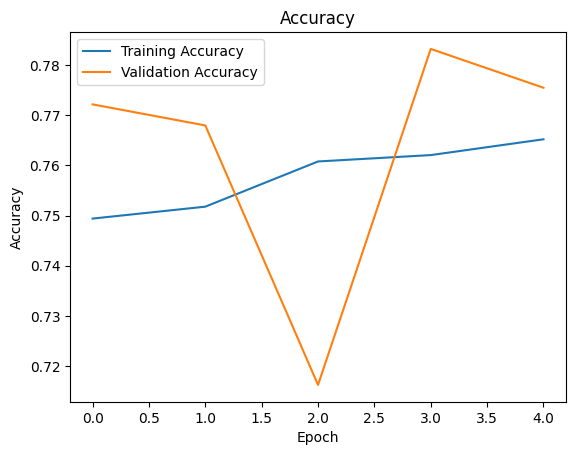

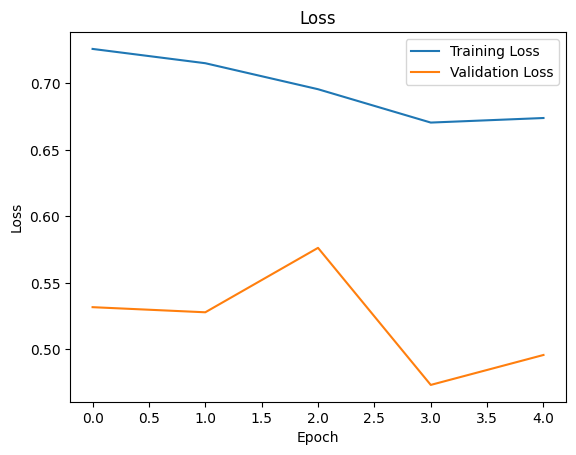

In [44]:
import matplotlib.pyplot as plt

# Get the training history
history = model.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_test, y_test), class_weight=class_weights_dict)

# Plot training history for accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Plot training history for loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()


####Training and Validation Loss Plot:
The top plot shows the loss (error) of the model during training and validation.
The x-axis represents the number of epochs (training iterations), and the y-axis represents the loss value.
The blue line represents the training loss, which indicates how well the model is fitting the training data. As the epochs progress, the training loss decreases.
The orange line represents the validation loss, which measures how well the model generalizes to unseen data (validation set). Ideally, we want both training and validation loss to decrease, but if the validation loss starts increasing while the training loss continues to decrease, it could indicate overfitting.
Training and Validation Accuracy Plot:
The bottom plot shows the accuracy of the model during training and validation.
Again, the x-axis represents the number of epochs, and the y-axis represents the accuracy value.
The blue line represents the training accuracy, showing how well the model predicts the training data. It increases as the model learns.
The orange line represents the validation accuracy, indicating how well the model performs on unseen validation data. If the validation accuracy plateaus or decreases while training accuracy keeps improving, it suggests overfitting.
In summary, these plots help monitor the model’s performance during training. Ideally, we want both loss to decrease and accuracy to increase steadily for both training and validation. If there’s a significant gap between training and validation performance, further investigation may be needed to improve the model’s generalization ability

In [45]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

142/142 [==============================] - 10s 69ms/step - loss: 0.4959 - accuracy: 0.7754
Test Accuracy: 0.7754471302032471


**`The confusion matrix`** is a table that is often used to describe the performance of a classification model. It compares the actual target values with the values predicted by the model. The rows of the matrix represent the actual classes, and the columns represent the predicted classes.

The main diagonal of the confusion matrix (from top left to bottom right) represents the number of correct predictions for each class. Off-diagonal elements represent instances that are misclassified. The higher the values on the diagonal, the better the model's performance. A perfect classifier would have values only on the diagonal.

142/142 [==============================] - 12s 84ms/step


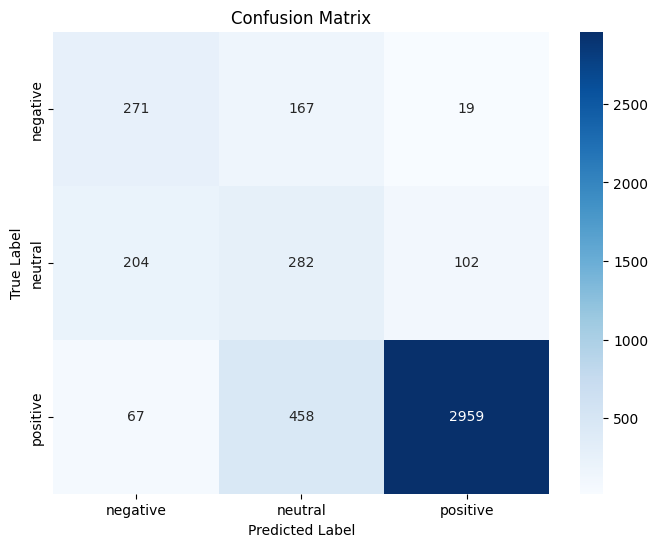

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the predictions on the test data
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_labels, yticklabels=sentiment_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Model Evaluation

since we are interested to check how our model is performing, we can feed in some unseen data to check the corrrect and incorrect classifcaion provided by the model.



In [51]:
# Define a real string for testing
test_string = "I love my life"

# Tokenize the test string
test_sequence = tokenizer.texts_to_sequences([test_string])

# Pad the sequence to make it of equal length
test_sequence_padded = pad_sequences(test_sequence, padding='post', maxlen=maxlen)

# Predict sentiment for the test string
predictions = model.predict(test_sequence_padded)

# Get the predicted sentiment label
sentiment_labels = ['negative', 'neutral', 'positive']
predicted_sentiment = sentiment_labels[np.argmax(predictions)]

print(f'Test String: "{test_string}"')
print(f'Predicted Sentiment: {predicted_sentiment}')

1/1 [==============================] - 0s 108ms/step
Test String: "I love my life"
Predicted Sentiment: positive


In [52]:
# Define a real string for testing
test_string = "I hate this dress"

# Tokenize the test string
test_sequence = tokenizer.texts_to_sequences([test_string])

# Pad the sequence to make it of equal length
test_sequence_padded = pad_sequences(test_sequence, padding='post', maxlen=maxlen)

# Predict sentiment for the test string
predictions = model.predict(test_sequence_padded)

# Get the predicted sentiment label
sentiment_labels = ['negative', 'neutral', 'positive']
predicted_sentiment = sentiment_labels[np.argmax(predictions)]

print(f'Test String: "{test_string}"')
print(f'Predicted Sentiment: {predicted_sentiment}')

1/1 [==============================] - 0s 104ms/step
Test String: "I hate this dress"
Predicted Sentiment: negative


In [57]:
# Define a real string for testing
test_string = "this is average"

# Tokenize the test string
test_sequence = tokenizer.texts_to_sequences([test_string])

# Pad the sequence to make it of equal length
test_sequence_padded = pad_sequences(test_sequence, padding='post', maxlen=maxlen)

# Predict sentiment for the test string
predictions = model.predict(test_sequence_padded)

# Get the predicted sentiment label
sentiment_labels = ['negative', 'neutral', 'positive']
predicted_sentiment = sentiment_labels[np.argmax(predictions)]

print(f'Test String: "{test_string}"')
print(f'Predicted Sentiment: {predicted_sentiment}')

1/1 [==============================] - 0s 103ms/step
Test String: "this is average"
Predicted Sentiment: negative


### **Conclusion**

- the model is performing correct in classifying class : positive

- the model is performing correct in classifying class : negative

- the model is performing incorrect in classifying class : Neutral

This means, we need to gather or work on class neutral